<a href="https://colab.research.google.com/github/AkibCoding/Fake-news-detection-using-svm-kernel/blob/main/bertfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2024-06-22 17:37:53.321492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 17:37:53.321607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 17:37:53.450325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,0.005760,0.999332,0.999299
2,0.000000,0.001043,0.999777,0.999767
3,0.000000,0.002522,0.999777,0.999767


Accuracy: 0.9997772828507795
F1-Score: 0.999766518795237


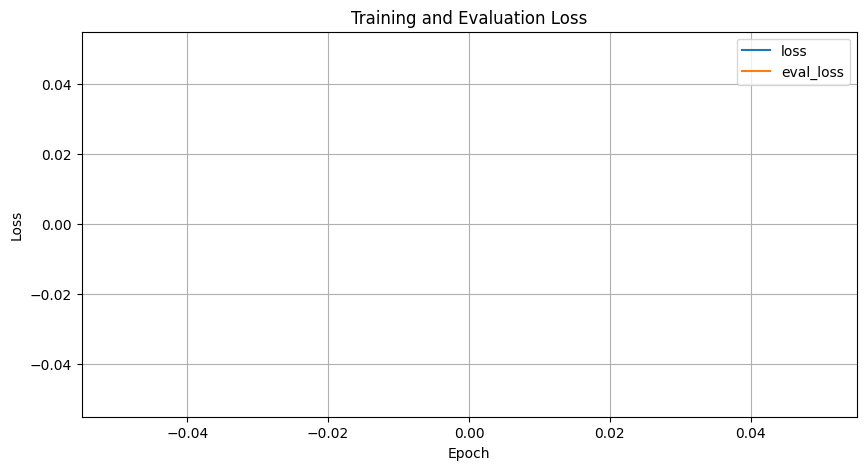

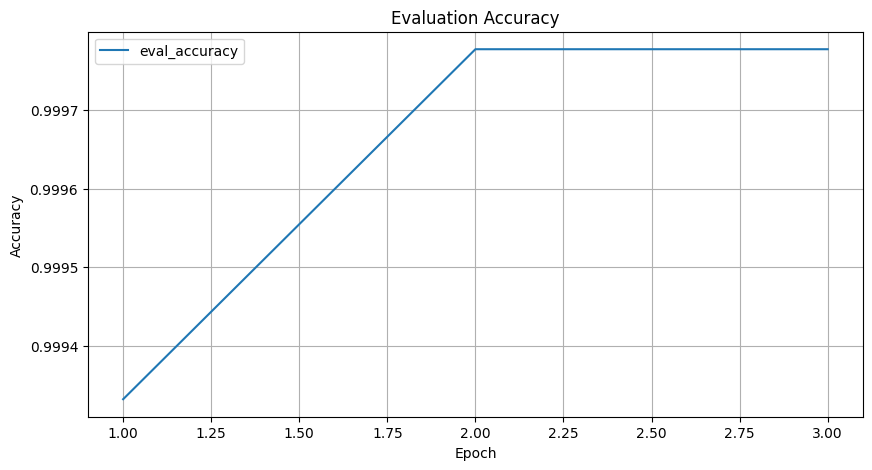

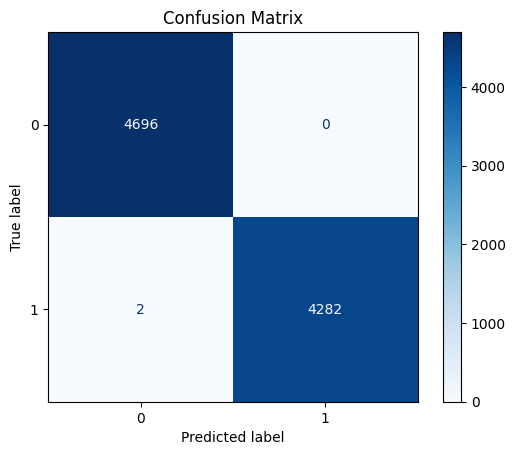

In [ ]:
# Install required libraries
!pip install transformers torch scikit-learn datasets

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset
df_true = pd.read_csv("/kaggle/input/fakenews/fake_dataset/True.csv")
df_fake = pd.read_csv("/kaggle/input/fakenews/fake_dataset/Fake.csv")

# Create a label column
df_true['label'] = 1
df_fake['label'] = 0

# Combine the datasets
df = pd.concat([df_true, df_fake], ignore_index=True)

# Preprocess text and labels
df['text'] = df['title'] + " " + df['text']
X = df['text'].values
y = df['label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)

train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Define compute metrics function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    return {"accuracy": accuracy, "f1": f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
train_result = trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()

# Print evaluation results
print(f"Accuracy: {eval_result['eval_accuracy']}")
print(f"F1-Score: {eval_result['eval_f1']}")

# Plot training graphs
logs = pd.DataFrame(trainer.state.log_history)
logs[['epoch', 'loss', 'eval_loss']].dropna().plot(x='epoch', figsize=(10, 5))
plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

logs[['epoch', 'eval_accuracy']].dropna().plot(x='epoch', figsize=(10, 5))
plt.title('Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

# Predict on test data
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

# Plot confusion matrix
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


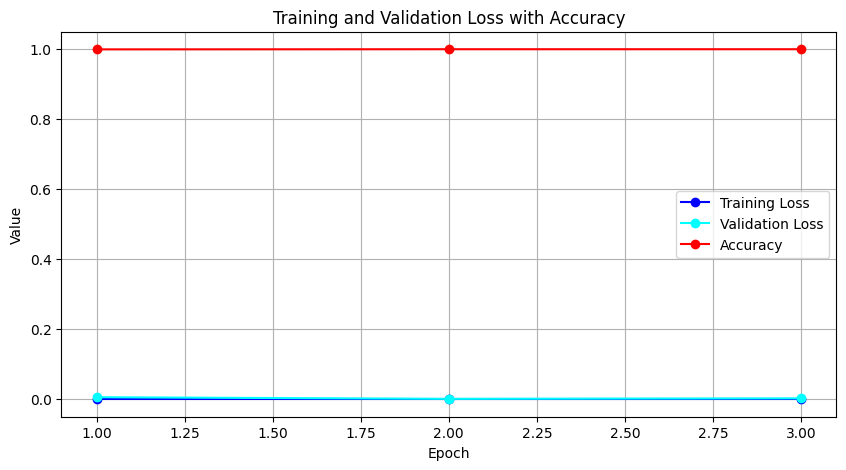

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3]
training_loss = [0.000000, 0.000000, 0.000000]
validation_loss = [0.005760, 0.001043, 0.002522]
accuracy = [0.999332, 0.999777, 0.999777]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='cyan')
plt.plot(epochs, accuracy, label='Accuracy', marker='o', color='red')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Loss with Accuracy')
plt.legend()
plt.grid()
plt.show()
